# PSP AC Astra Modeling

### Model Derivation, SCP Problem Definition for MPC, and Solving with SCPToolbox

In [4]:
import Pkg
Pkg.activate("")

using SCPToolbox
using PyCall, PyPlot, Colors, LinearAlgebra, Latexify, Symbolics
using Plots, Measures

# Import the different possible low-level convex solvers
using ECOS
# using Ipopt
# using SCS
# using OSQP

  Activating new project at `C:\Users\thatf\Documents\PSP AC`


LoadError: ArgumentError: Package Plots not found in current path, maybe you meant `import/using .Plots`.
- Otherwise, run `import Pkg; Pkg.add("Plots")` to install the Plots package.

## Model Derivation

### Problem Description

#### General Description

#### Assumptions

#### States

The Euler angle definition chosen is 121 sequence because there won't be a singularity when pointing straight up and it will be simple to express rotations about the x direction in the body frame. 

In [2]:
r = Symbolics.variables(:r, 1:3)
v = Symbolics.variables(:v, 1:3)
θ = Symbolics.variables(:θ, 1:3)
ω = Symbolics.variables(:ω, 1:3)

x = [r; v; θ; ω]

x_latex = latexify(x);
L"The state vector is $$x = %$x_latex$$"

L"The state vector is $$x = \begin{equation}
\left[
\begin{array}{c}
r_1 \\
r_2 \\
r_3 \\
v_1 \\
v_2 \\
v_3 \\
\theta_1 \\
\theta_2 \\
\theta_3 \\
\omega_1 \\
\omega_2 \\
\omega_3 \\
\end{array}
\right]
\end{equation}
$$"

The state vector is
$$
x = `{julia} latexify(x)`
$$

#### Controls

In [3]:
@variables σ, γ
T = Symbolics.variables(:T, 1:3)

u = [T; σ; γ]

u_latex = latexify(u)
L"The control vector is $$u = %$u_latex$$"

L"The control vector is $$u = \begin{equation}
\left[
\begin{array}{c}
T_1 \\
T_2 \\
T_3 \\
\sigma \\
\gamma \\
\end{array}
\right]
\end{equation}
$$"

The control vector is
$$
u = `{julia} latexify(u)`
$$

#### Parameters

In [4]:
@variables t_f

p = [t_f]

p_latex = latexify(p)
L"The parameter vector is $$p = %$p_latex$$"

L"The parameter vector is $$p = \begin{equation}
\left[
\begin{array}{c}
t_{f} \\
\end{array}
\right]
\end{equation}
$$"

The parameter vector is
$$
p = `{julia} latexify(p)`
$$

#### Constraints

There are two types of constraints. Path is the general term for the state and control.

1. Convex Path Constraints

Constraints which constraint the path to be apart of a closed and bounded convex set.
These can be transformed into constraining the path to be inside some convex cone.

|    Label        | Notation     |     Name      | Definition |
|:---------------:|:----:|:-------------:|:----------:|
|`UNCONSTRAINED`|  $\mathbb{K}_{ \lesseqgtr}$ | Unconstrained cone  |  $$\{x\in\mathbb{R}^n\}$$ |
|`ZERO`|  $\mathbb{K}_{=0}$ | Zero cone | $\{x\in\mathbb{R}^n\mid x=0\}$   |
|`NONPOS`|  $\mathbb{K}_{\leq 0}$ | Non-positive orthant  | $\{x\in\mathbb{R}^n\mid x\leq 0\}$|
|`L1` | $\mathbb{K}_{1}$ | $l_1$ norm cone| $\{(t,x)\in\mathbb{R}\times\mathbb{R}^n\mid \lVert x\rVert_1\leq t\}$ |
|`SOC`| $\mathbb{K}_{2}$ | $l_2$ norm cone| $\{(t,x)\in\mathbb{R}\times\mathbb{R}^n\mid \lVert x\rVert_2\leq t\}$ |
|`LINF`| $\mathbb{K}_{\infty}$ |  $l_\infty$ norm cone |  $\{(t,x)\in\mathbb{R}\times\mathbb{R}^n\mid \lVert x\rVert_\infty\leq t\}$ |
|`GEOM`|  $\mathbb{K}_{\text{GM}}$ | Geometric mean cone | $ \big\{ (t,x)\in\mathbb{R}\times\mathbb{R}^n\mid \left(\prod_{i=1}^n x_i\right)^{1/n} \geq t \big\}$ |
|`EXP`|  $\mathbb{K}_{\text{EXP}}$ | Exponential cone | $\{(x,y,z)\in \mathbb{R}\times \mathbb{R} \times \mathbb{R} \mid y\,\text{exp}(x/y) \leq z,~y>0\}$ |

2. Nonconvex Path Constraints

Constraints which are too complex to be transformed into a set of convex cone constraints.
SCP handles these by linearizing them.

**State**

1. Glideslope 
\begin{equation*}
\left\{r\in\mathbb{R}^3~|~ ||r|| \cos(\gamma_{gs}) \leq e_3^\top r\right\}
\end{equation*}
\begin{equation*}
\left\{r\in\mathbb{R}^3~|~ ||r|| \cos(\gamma_{gs}) \leq r_3 \right\}
\end{equation*}
\begin{equation*}
\left\{r\in\mathbb{R}^3~|~ ||r|| \leq \frac{r_3}{\cos(\gamma_{gs})} \in \mathbb{K}_{2} \right\}
\end{equation*}

In [5]:
#@variables γ_gs
## Constants for state constraints
#csc = [γ_gs]

# State Constraint Constant
γ_gs_ = deg2rad(45.0); # [rad] Glideslope angle (measured from the horizon)

# Define constraints
# Glideslope - replace with half space? (if relaxing landing site bc)
glideslope(r, clp) = @add_constraint(clp, SOC, r -> [r[3] / cos(γ_gs_); r])

state_constraints(t, k, x, p, pbm, clp) = begin
        r, v, θ, ω = x[1:3], x[4:6], x[7:9], x[10:12]
    
        glideslope(r, clp)
    end;

**Control**

1. Thrust cone
\begin{equation*}
\left\{T\in\mathbb{R}^3~|~ b_1^\top T \geq ||T|| \cos(\gamma_{T})\right\}
\end{equation*}
Simplifying,
\begin{equation*}
\left\{T\in\mathbb{R}^3~|~ T_1 \geq ||T|| \cos(\gamma_{T})\right\}
\end{equation*}

This constraint is not a linear or quadratic convex constraint, but a more general convex constraint. To remedy this, we use the technique of Lossless Convexification to add a slack variable, $\sigma$, which is equal to $||T||$ at the optimal solution to the optimization problem. This means the thrust cone constraint now becomes
\begin{equation*}
\left\{T\in\mathbb{R}^3,\sigma\in\mathbb{R}~|~  \sigma \cos(\gamma_{T}) - T_1 \leq 0 \in \mathbb{K}_{\leq 0} \right\}
\end{equation*}
To make the lossless convexification hold, the following constraint must be added
\begin{equation*}
\left\{T\in\mathbb{R}^3,\sigma\in\mathbb{R}~|~ ||T|| \leq \sigma \in \mathbb{K}_{2} \right\}
\end{equation*}

2. Thrust limit
\begin{equation*}
\left\{T\in\mathbb{R}^3~|~ ||T|| \leq T_{max} \right\}
\end{equation*}
Using the slack variable $\sigma$, the constraint becomes
\begin{equation*}
\left\{\sigma\in\mathbb{R}~|~ \sigma - T_{max} \leq 0 \in \mathbb{K}_{\leq 0} \right\}
\end{equation*}

3. Vane angle
\begin{equation*}
\left\{γ\in\mathbb{R}~|~ |γ| \leq γ_{max} \in \mathbb{K}_{1} \right\}
\end{equation*}

In [6]:
#@variables T_max, γ_max, δ_max
## Constants for control constraints
#cuc = [T_max, γ_max, δ_max]

# Control Constraint Constants
T_max_ = 500e3 # [N] Maximum thrust
δ_max_ = deg2rad(7.0); # [rad] Maximum gimbal angle
γ_max_ = deg2rad(45); # [rad] Maximum vane angle


# Define constraints
thrust_limit(σ, clp) = @add_constraint(clp, NONPOS, σ -> σ - T_max_)

vane_limit(γ, clp) = @add_constraint(clp, L1, γ -> [γ_max_; γ]);

# Thrust Cone
thrust_cone(T, σ, clp) = @add_constraint(clp, NONPOS, "Thrust Cone", (T, σ) -> σ * cos(δ_max_) - T[1])
lcvx_thrust_equality(T, σ, clp) = @add_constraint(clp, SOC, "lcvx_equality_thrust_cone", (T, σ) -> [σ; T]);

control_constraints(t, k, u, p, pbm, clp) = begin
        T, σ, γ = u[1:3], u[4], u[5]
                
        thrust_limit(σ, clp)
        vane_limit(γ, clp)
        thrust_cone(T, σ, clp)
        lcvx_thrust_equality(T, σ, clp)
    end;

**Parameter**

1. Final time range 
\begin{equation*}
\left\{t_f\in\mathbb{R}~|~ t_{fmin} \leq t_f \leq t_{fmax} \right\}
\end{equation*}

#### Constants
Where define actual values?

In [7]:
# Environment Parameters
@variables g
g_ = 9.81; # [m/s^2] Earth gravity


# Mechanical Parameters
@variables m
m_ = 25e3 # [kg] Initial mass

@variables L
L_ = 0.5 # [m] Thrust lever arm

J = Symbolics.variables(:J, 1:3)
J_t = 100e3; # [kg*m^2] Moment of inertia
J_a = J_t / 10;
J_ = [J_a; J_t; J_t];


# General Constant Vector
c = [g; m; L; J]
c_ = [g_; m_; L_; J_];

The constants are
$$
c = `{julia} latexify(c_)`
$$

#### Boundary Conditions

In [8]:
# Initial state
r0 = Symbolics.variables(:r_0, 1:3)
r0_ = [300, -400, 800] # [m]

v0 = Symbolics.variables(:v_0, 1:3)
v0_ = [0, 0, -10] # [m / s]

θ0 = Symbolics.variables(:θ_0, 1:3)
θ0_ = deg2rad.([10, 90, 0]) # [rad] 121 Euler sequence

ω0 = Symbolics.variables(:ω_0, 1:3)
ω0_ = deg2rad.([90, 10, 0]) # [rad / s]

x0 = [r0; v0; θ0; ω0]
x_0 = [r0_; v0_; θ0_; ω0_];

# Terminal state
r1 = zeros(3) # Potentially relax this constraint into the objective function - would have to change glideslope to be centered at new final position...
v1 = zeros(3)
θ1 = [θ[1], pi/2, 0] # Constrain to be upright
ω1 = zeros(3)

x1 = [r1; v1; θ1; ω1];

The boundary conditions are
$$
x_0  = `{julia} latexify(x_0)`,
x_f = `{julia} latexify(x1)`
$$

In [9]:
g_ic = x - x0
g_tc = x - x1;

### Equations of Motions

#### Euler's Law
$$
\begin{cases}
\dot\omega_1 = \frac{T + (I_2 - I_3)\omega_2\omega_3}{I_1} \\
\dot\omega_2 = \frac{T + (I_3 - I_1)\omega_3\omega_1}{I_2} \\
\dot\omega_3 = \frac{T + (I_1 - I_2)\omega_1\omega_2}{I_3} \\
\end{cases}
$$

#### Newton's Second Law
$$F = ma$$

#### Euler Angle Update - 121 Sequence
$$
\begin{cases}
B^{-1} = \frac{1}{\sin(\theta_2)}\begin{pmatrix} 0 & \sin(\theta_3) & \cos(\theta_3) \\
0 & \sin(\theta_2) \cos(\theta_3) & -\sin(\theta_2) \sin(\theta_3) \\
\sin(\theta_2) & -\cos(\theta_2) \sin(\theta_3) & -\cos(\theta_2) \cos(\theta_3)
\end{pmatrix} \\
\dot\theta = B^{-1} \vec\omega
\end{cases}
$$

### Dynamics

In [10]:
x_dot = v
Rxθ1 = [1 0 0; 
        0 cos(θ[1]) -sin(θ[1]); 
        0 sin(θ[1]) cos(θ[1])]
Ryθ2 = [cos(θ[2]) 0 sin(θ[2]); 
        0 1 0; 
        -sin(θ[2]) 0 cos(θ[2])]
Rxθ3 = [1 0 0; 
        0 cos(θ[3]) -sin(θ[3]); 
        0 sin(θ[3]) cos(θ[3])]
C_be = (Rxθ1 * Ryθ2 * Rxθ3)
C_eb = (Rxθ1 * Ryθ2 * Rxθ3)'
v_dot = C_eb * T / m * cos(γ) + [0; 0; -g]
B_inv = 1 ./ sin(θ[2]) * [0 sin(θ[3]) cos(θ[3]); 
    0 sin(θ[2]) * cos(θ[3]) -sin(θ[2]) * sin(θ[3]); 
    sin(θ[2]) -cos(θ[2]) * sin(θ[3]) -cos(θ[2]) * cos(θ[3])]
θ_dot = B_inv * ω # Need actual update
M = σ .* sin(γ) .* [1, 0, 0] + cross([-L, 0, 0], T)
ω_dot = (M .+ (J[[2, 3, 1]] .- J[[3, 1, 2]]) .* ω[[2, 3, 1]] .* ω[[3, 1, 2]]) ./ J
f_ = [x_dot; v_dot; θ_dot; ω_dot]

12-element Vector{Num}:
                                                                                                                                         v₁
                                                                                                                                         v₂
                                                                                                                                         v₃
                                                                        ((T₁*cos(θ₂) + T₂*sin(θ₁)*sin(θ₂) - T₃*sin(θ₂)*cos(θ₁))*cos(γ)) / m
        ((T₁*sin(θ₃)*sin(θ₂) + T₂*(cos(θ₃)*cos(θ₁) - cos(θ₂)*sin(θ₁)*sin(θ₃)) + T₃*(cos(θ₃)*sin(θ₁) + cos(θ₂)*sin(θ₃)*cos(θ₁)))*cos(γ)) / m
 -g + ((T₁*cos(θ₃)*sin(θ₂) + T₂*(-sin(θ₃)*cos(θ₁) - cos(θ₂)*cos(θ₃)*sin(θ₁)) + T₃*(-sin(θ₁)*sin(θ₃) + cos(θ₂)*cos(θ₃)*cos(θ₁)))*cos(γ)) / m
                                                                                            (sin(θ₃)*ω₂) / sin(θ₂) + (cos(θ₃)*ω₃) / sin(

### Cost Function

Assuming Bolza Form of the cost function:
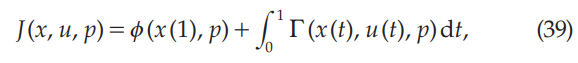

#### Terminal Cost $\phi(x(1), p)$

Altitude : $r_z^2$

In [11]:
ϕ(x, p) = x[3]^2;# + p[1] / tf_min * 0.01;

#### Running Cost $\Gamma(x(t), u(t), p)$

Thrust: $\frac{||T||}{T_{max}} = \frac{\sigma}{T_{max}}$

Vane Angle: $(\frac{\gamma}{\gamma_{max}})^2$

In [12]:
Γ(x, u, p) = u[4] / T_max_ + (u[5] / γ_max_)^2;# + x[10]^2;

## SCP Problem Definition for MPC

SCP: Successive Convex Programming
MPC: Model Predictive Control

### Optimal Control Optimization Problem Definition

#### General Form
![image.png](attachment:987ceadc-616f-48dc-8460-190016705809.png)

### SCP Optimization Problem Definition

Scale the dynamics by the final time so that the final time can be a free parameter.

In [13]:
f_n = f_ * t_f

12-element Vector{Num}:
                                                                                                                                              t_f*v₁
                                                                                                                                              t_f*v₂
                                                                                                                                              t_f*v₃
                                                                                      ((T₁*cos(θ₂) + T₂*sin(θ₁)*sin(θ₂) - T₃*sin(θ₂)*cos(θ₁))*t_f*cos(γ)) / m
                      ((T₁*sin(θ₃)*sin(θ₂) + T₂*(cos(θ₃)*cos(θ₁) - cos(θ₂)*sin(θ₁)*sin(θ₃)) + T₃*(cos(θ₃)*sin(θ₁) + cos(θ₂)*sin(θ₃)*cos(θ₁)))*t_f*cos(γ)) / m
 (-g + ((T₁*cos(θ₃)*sin(θ₂) + T₂*(-sin(θ₃)*cos(θ₁) - cos(θ₂)*cos(θ₃)*sin(θ₁)) + T₃*(-sin(θ₁)*sin(θ₃) + cos(θ₂)*cos(θ₃)*cos(θ₁)))*cos(γ)) / m)*t_f
                                                                   

#### Jacobian Calculations

State: $A = \nabla_x f =$

In [14]:
A_l = Symbolics.jacobian(f_n, x)

12×12 Matrix{Num}:
 0  0  0  t_f   0    0   …               0
 0  0  0   0   t_f   0                   0
 0  0  0   0    0   t_f                  0
 0  0  0   0    0    0                   0
 0  0  0   0    0    0                   0
 0  0  0   0    0    0   …               0
 0  0  0   0    0    0                 (t_f*cos(θ₃)) / sin(θ₂)
 0  0  0   0    0    0                 -t_f*sin(θ₃)
 0  0  0   0    0    0                (-t_f*cos(θ₂)*cos(θ₃)) / sin(θ₂)
 0  0  0   0    0    0       ((J₂ - J₃)*t_f*ω₂) / J₁
 0  0  0   0    0    0   …  ((-J₁ + J₃)*t_f*ω₁) / J₂
 0  0  0   0    0    0                   0

Control: $B = \nabla_u f =$

In [15]:
B_l = Symbolics.jacobian(f_n, u)

12×5 Matrix{Num}:
   0                               …                                                                                                                              0
   0                                                                                                                                                              0
   0                                                                                                                                                              0
 (t_f*cos(γ)*cos(θ₂)) / m                                                                               (-(T₁*cos(θ₂) + T₂*sin(θ₁)*sin(θ₂) - T₃*sin(θ₂)*cos(θ₁))*t_f*sin(γ)) / m
 (t_f*cos(γ)*sin(θ₃)*sin(θ₂)) / m       (-(T₁*sin(θ₃)*sin(θ₂) + T₂*(cos(θ₃)*cos(θ₁) - cos(θ₂)*sin(θ₁)*sin(θ₃)) + T₃*(cos(θ₃)*sin(θ₁) + cos(θ₂)*sin(θ₃)*cos(θ₁)))*t_f*sin(γ)) / m
 (t_f*cos(γ)*cos(θ₃)*sin(θ₂)) / m  …  (-(T₁*cos(θ₃)*sin(θ₂) + T₂*(-sin(θ₃)*cos(θ₁) - cos(θ₂)*cos(θ₃)*sin(θ₁)) + T₃*(-sin(θ₁)*sin(θ₃) + c

Parameter: $F = \nabla_p f =$

In [16]:
F_l = Symbolics.jacobian(f_n, p)

12×1 Matrix{Num}:
                                                                                                                                         v₁
                                                                                                                                         v₂
                                                                                                                                         v₃
                                                                        ((T₁*cos(θ₂) + T₂*sin(θ₁)*sin(θ₂) - T₃*sin(θ₂)*cos(θ₁))*cos(γ)) / m
        ((T₁*sin(θ₃)*sin(θ₂) + T₂*(cos(θ₃)*cos(θ₁) - cos(θ₂)*sin(θ₁)*sin(θ₃)) + T₃*(cos(θ₃)*sin(θ₁) + cos(θ₂)*sin(θ₃)*cos(θ₁)))*cos(γ)) / m
 -g + ((T₁*cos(θ₃)*sin(θ₂) + T₂*(-sin(θ₃)*cos(θ₁) - cos(θ₂)*cos(θ₃)*sin(θ₁)) + T₃*(-sin(θ₁)*sin(θ₃) + cos(θ₂)*cos(θ₃)*cos(θ₁)))*cos(γ)) / m
                                                                                            (sin(θ₃)*ω₂) / sin(θ₂) + (cos(θ₃)*ω₃) / sin(θ₂)
  

Nonconvex Path Constraint

N/A - No nonconvex path constraints 

In [17]:
#C_l = Symbolics.jacobian(s_n, x)
#D_l = Symbolics.jacobian(s_n, u)
#G_l = Symbolics.jacobian(s_n, p)

Boundary Conditions 

Initial conditions: $H_0 = \nabla_x g_{ic} =$

In [18]:
#K_0 = Symbolics.jacobian(g_ic, p)

H_0 = Symbolics.jacobian(g_ic, x)

12×12 Matrix{Num}:
 1  0  0  0  0  0  0  0  0  0  0  0
 0  1  0  0  0  0  0  0  0  0  0  0
 0  0  1  0  0  0  0  0  0  0  0  0
 0  0  0  1  0  0  0  0  0  0  0  0
 0  0  0  0  1  0  0  0  0  0  0  0
 0  0  0  0  0  1  0  0  0  0  0  0
 0  0  0  0  0  0  1  0  0  0  0  0
 0  0  0  0  0  0  0  1  0  0  0  0
 0  0  0  0  0  0  0  0  1  0  0  0
 0  0  0  0  0  0  0  0  0  1  0  0
 0  0  0  0  0  0  0  0  0  0  1  0
 0  0  0  0  0  0  0  0  0  0  0  1

Terminal conditions: $H_f = \nabla_x g_{tc} =$

In [19]:
#K_f = Symbolics.jacobian(g_tc, p)

H_f = Symbolics.jacobian(g_tc, x)

12×12 Matrix{Num}:
 1  0  0  0  0  0  0  0  0  0  0  0
 0  1  0  0  0  0  0  0  0  0  0  0
 0  0  1  0  0  0  0  0  0  0  0  0
 0  0  0  1  0  0  0  0  0  0  0  0
 0  0  0  0  1  0  0  0  0  0  0  0
 0  0  0  0  0  1  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  1  0  0  0  0
 0  0  0  0  0  0  0  0  1  0  0  0
 0  0  0  0  0  0  0  0  0  1  0  0
 0  0  0  0  0  0  0  0  0  0  1  0
 0  0  0  0  0  0  0  0  0  0  0  1

#### Linearized Optimization Problem Definition
![image.png](attachment:e3a10da5-6cb2-4ca7-9589-b4a901eb7e87.png)

### Initial Guess

The SCP algorithms do not require the initial guess to be feasible with respect to the dynamics or nonconvex path constraints, 
but they do require the guess to be feasible with respect to the convex path constraints

State
- r: Straight line interpolation
- v: Constant (from r)
- θ: Straight line interpolation
- ω: Constant (from θ)

Control
- T: Half max thrust, no thrust vectoring: $T_{guess} = \frac{1}{2}T_{max}\hat b_1$
- γ: Zero vane angle (should never be very large)

In [20]:
"""
    straightline_interpolate(v0, vf, N)

Straight-line interpolation between two points. Compute a straight-line
interpolation between an initial and a final vector, on a grid of N points.

# Arguments
- `v0`: starting vector.
- `vf`: ending vector.
- `N`: number of vectors in between (including endpoints).

# Returns
- `v`: the resulting interpolation (a matrix, k-th column is the k-th vector,
  k=1,...,N).
"""
function straightline_interpolate(v0::RealVector, vf::RealVector, N::Int)::RealMatrix

    # Initialize
    nv = length(v0)
    v = zeros(nv, N)

    # Interpolation grid
    times = LinRange(0.0, 1.0, N)
    t_endpts = [times[1], times[end]]
    v_endpts = hcat(v0, vf)

    for k = 1:N
        v[:, k] = linterp(times[k], v_endpts, t_endpts)
    end

    return v
end

"""
    get_interval(x, grid)

Compute grid bin. Get which grid interval a real number belongs to.

# Arguments
- `x`: the real number.
- `grid`: the discrete grid on the real line.

# Returns
- `k`: the interval of the grid the the real number is in.
"""
function get_interval(x::RealValue, grid::RealVector)::Int
    k = sum(x .> grid)
    if k == 0
        k = 1
    end
    return k
end

"""
    linterp(t, f_cps, t_grid)

Linear interpolation on a grid. Linearly interpolate a discrete function on a
time grid. In other words, get the function value assuming that it is a
continuous and piecewise affine function.

# Arguments
- `t`: the time at which to get the function value.
- `f_cps`: the control points of the function, stored as columns of a matrix.
- `t_grid`: the discrete time nodes.

# Returns
- `f_t`: the function value at time t.
"""
function linterp(
    t::RealValue,
    f_cps::RealArray,
    t_grid::RealVector,
)::Union{RealValue,RealArray}
    t = max(t_grid[1], min(t_grid[end], t)) # Saturate to time grid
    k = get_interval(t, t_grid)
    c = (t_grid[k+1] - t) / (t_grid[k+1] - t_grid[k])
    dimfill = fill(:, ndims(f_cps) - 1)
    f_t = c * f_cps[dimfill..., k] + (1 - c) * f_cps[dimfill..., k+1]
    return f_t
end;

In [21]:
# Terminal state
r1_ = zeros(3) # [m]
v1_ = zeros(3) # [m / s]
θ1_ = deg2rad.([θ0_[1], 90, 0]) # [rad] 121 Euler sequence
ω1_ = zeros(3) # [rad / s]

x_f = [r1_; v1_; θ1_; ω1_];

# Control guess
T_guess = 0.8*T_max_ # [N] Initial thrust guess
input_guess(N) = straightline_interpolate([T_guess; 0; 0; T_guess; 0], [T_guess; 0; 0; T_guess; 0], N);

# Parameter guess
v_0, v_f = x_0[4:6], x_f[4:6]
tf_guess = norm(v_f-v_0 + sqrt.(2 * [0; 0; g_] * x_0[3]), 2)/(T_guess/m_-g_)

# State guess
state_guess(N) = begin
    x_guess = straightline_interpolate(x_0, x_f, N)
    x_guess[10, :] .= 0
    x_guess[11, :] .= (x_f[8]-x_0[8])/tf_guess
    x_guess[12, :] .= -(x_f[7]-x_0[7])/tf_guess
    return x_guess
end;

## SCP Toolbox Code and Solution

### Set Up Problem

In [22]:
pbm = TrajectoryProblem();
algo = :ptr;

# Dimensions
n = length(x)
md = length(u)
d = length(p);
problem_set_dims!(pbm, n, md, d)

# Dynamics
build_func(func) = begin
    vfunc = eval(build_function(func, [x; u; p; c])[1]) 
    bfunc(t, k, x, u, p, pbm) = vfunc([x; u; p; c_])
    return bfunc
end;

problem_set_dynamics!(pbm, build_func(f_n), build_func(A_l), build_func(B_l), build_func(F_l))

# Boundary Conditions
build_bc(func) = begin
    vfunc = eval(build_function(func, [x; x0])[1]) 
    bfunc(x, p, pbm) = vfunc([x; x_0])
    return bfunc
end;

problem_set_bc!(pbm, :ic, build_bc(g_ic), build_bc(H_0))
problem_set_bc!(pbm, :tc, build_bc(g_tc), build_bc(H_f));

# Constraints
problem_set_X!(pbm, (t, k, x, p, pbm, clp) -> begin
        #@add_constraint(clp, NONPOS, p -> tf_min - p[1])
        #glideslope(x, clp)
        state_constraints(t, k, x, p, pbm, clp)
    end)

problem_set_U!(pbm, (t, k, u, p, pbm, clp) -> begin
        T, σ, γ = u[1:3], u[4], u[5]

        control_constraints(t, k, u, p, pbm, clp)
    end)

# Cost Function
#build_terminal(func) = begin
#    vfunc = eval(build_function(func, [x; p])[1]) 
#    bfunc(x, p, pbm) = vfunc([x; p])[1]
#    return bfunc
#end;
#
#build_running(func) = begin
#    vfunc = eval(build_function(func, [x; u; p; c])[1]) 
#    bfunc(t, k, x, u, p, pbm) = vfunc([x; u; p; c_])[1]
#    return bfunc
#end
#
#problem_set_terminal_cost!(pbm, build_terminal([ϕ]))
#problem_set_running_cost!(pbm, algo, build_running([Γ]))

problem_set_terminal_cost!(pbm, (x, p, pbm) -> ϕ(x, p))
problem_set_running_cost!(pbm, algo, (t, k, x, u, p, pbm) -> Γ(x, u, p))

# Initial Guess
problem_set_guess!(pbm, (N, pbm) -> begin
    x = state_guess(N)
    u = input_guess(N)
    p = [tf_guess]
    return x, u, p
end)

# Variable Scaling
rx_range_box = max(x_0[1], 1.0)
ry_range_box = max(x_0[2], 1.0)
rz_range_box = max(x_0[3], 1.0)
vx_range_box = max(abs(x_0[4]), 1.0)
vy_range_box = max(abs(x_0[5]), 1.0)
vz_range_box = min(x_0[6], -1.0)
θ_range_box = deg2rad(20.0)
ω_range_box = max(abs(x_0[10]), deg2rad(5.0))

thrust_range = (0, T_max_)

problem_advise_scale!(pbm, :state, 1, (-rx_range_box, rx_range_box))
problem_advise_scale!(pbm, :state, 2, (-ry_range_box, ry_range_box))
problem_advise_scale!(pbm, :state, 3, (0, rz_range_box))
problem_advise_scale!(pbm, :state, 4, (-vx_range_box, vx_range_box))
problem_advise_scale!(pbm, :state, 5, (-vy_range_box, vy_range_box))
problem_advise_scale!(pbm, :state, 6, (vz_range_box, 0.0))
problem_advise_scale!(pbm, :state, 7, (-θ_range_box, θ_range_box))
problem_advise_scale!(pbm, :state, 8, (-θ_range_box, θ_range_box))
problem_advise_scale!(pbm, :state, 9, (-θ_range_box, θ_range_box))
problem_advise_scale!(pbm, :state, 10, (-ω_range_box, ω_range_box))
problem_advise_scale!(pbm, :state, 11, (-ω_range_box, ω_range_box))
problem_advise_scale!(pbm, :state, 12, (-ω_range_box, ω_range_box))

problem_advise_scale!(pbm, :input, 1, thrust_range)
problem_advise_scale!(pbm, :input, 2, thrust_range)
problem_advise_scale!(pbm, :input, 3, thrust_range)
problem_advise_scale!(pbm, :input, 4, thrust_range)
problem_advise_scale!(pbm, :input, 5, (-γ_max_, γ_max_))

problem_advise_scale!(pbm, :parameter, 1, (0.5*tf_guess, tf_guess));

### Solve Optimization Problem

Define solver parameters and print the solution state at each iteration

In [23]:
## Parameters
#N, Nsub = 15, 15
#iter_max = 30
#disc_method = FOH
#wvc, wtr = 1e1, 1e-1
#feas_tol = 5e-3
#ε_abs, ε_rel = 1e-5, 1e-4
#q_tr = Inf
#q_exit = Inf
#solver, solver_options = ECOS, Dict("verbose"=>0)      
#
#pars = PTR.Parameters(N, Nsub, iter_max, disc_method, wvc, wtr, ε_abs,
#                      ε_rel, feas_tol, q_tr, q_exit, solver, solver_options);
#
#ptr_pbm = PTR.create(pars, pbm)
#sol, history = PTR.solve(ptr_pbm);

### Plot Solution

In [24]:
#_sol = history.subproblems[end].sol
#
#tf = _sol.p[1]
#xd = _sol.xd
#ud = _sol.ud
#vd = _sol.vd
#p_sol = _sol.p
#td = sol.td*tf
#
#Nc = 100
#tc = LinRange(0, tf, Nc)
#xc = hcat([sample(sol.xc, t) for t in LinRange(0, 1, Nc)]...)
#uc = hcat([sample(sol.uc, t) for t in LinRange(0, 1, Nc)]...)
#
#tf_values = [spbm.sol.p[1] for spbm in history.subproblems]
#pushfirst!(tf_values, history.subproblems[1].ref.p[1]);

In [25]:
#The final time guess and final time of the solution are
#$$
#t_{fguess} = `{julia} round(tf_guess, digits = 3)`s,
#t_{f} = `{julia} round(p_sol[1], digits = 3)`s
#$$

In [26]:
## define a function that returns a Plots.Shape
#rectangle(w, h, x, y, bx) = begin 
#    P = [-w/2 w/2 w/2 -w/2; 0 0 h h]
#    by = [0 1; -1 0] * bx
#    P_prime = hcat([[0 -1; 1 0] * [bx by] * P[:, i] for i in range(1, 4)]...)
#    P_prime = P_prime .+ [x; y]
#    
#    return Shape(P_prime[1, :], P_prime[2, :])
#end
#
#rectangle_norot(w, h, x, y) = begin 
#    P = [-w/2 w/2 w/2 -w/2; 0 0 h h]
#    P = P .+ [x; y]
#    
#    return Shape(P[1, :], P[2, :])
#end
#
#Xd = xd[1, :]' .* ones(length(xd[2, :]))
#Yd = ones(length(xd[1, :]))' .* xd[2, :]
#Zd = sqrt.((Xd .^ 2 + Yd .^ 2)) * tan(γ_gs_);
#
#θ_ = xc[7:9, :]
#b_x = hcat([substitute(C_be, Dict([θ[1] => θ_[1, i], θ[2] => θ_[2, i], θ[3] => θ_[3, i]]))' * [1, 0, 0] for i in range(1, length(tc))]...)
#b_y = hcat([substitute(C_be, Dict([θ[1] => θ_[1, i], θ[2] => θ_[2, i], θ[3] => θ_[3, i]]))' * [0, 1, 0] for i in range(1, length(tc))]...)
#b_z = hcat([substitute(C_be, Dict([θ[1] => θ_[1, i], θ[2] => θ_[2, i], θ[3] => θ_[3, i]]))' * [0, 0, 1] for i in range(1, length(tc))]...)
#
#T_ = uc[1:3, :]
#T_e = hcat([substitute(C_be, Dict([θ[1] => θ_[1, i], θ[2] => θ_[2, i], θ[3] => θ_[3, i]]))' * T_[:, i] for i in range(1, length(tc))]...)
#
#gimbal_r = [acos(dot([1; 0; 0], T_[:, i]) / norm(T_[:, i])) * 180 / pi for i in range(1, length(tc))]
#gimbal_θ = (atan.(uc[3,:], uc[2, :])) .+ pi 
#
#Plots.gr()
#
#velocity = [norm(xc[4:6, i]) for i in range(1, length(tc))]
#
#a = Animation()
#
#z_max = max(xc[3, :]...)
#x_lim = (min(min(xc[1, :]...), -z_max / 10), max(max(xc[1, :]...), z_max / 10))
#y_lim = (min(min(xc[2, :]...), -z_max / 10), max(max(xc[2, :]...), z_max / 10))
#
#for i in 1:length(tc)
#
#    l = @layout [a; b c; d]
#
#    xz_angle = asin(norm(cross([b_x[1, i], 0, b_x[3, i]], [1,0,0])) / norm([b_x[1, i], 0, b_x[3, i]]))
#    p1 = Plots.plot(xc[1, :], xc[3, :], lc=:viridis, line_z=velocity, label = "", colorbar_title = "Speed")
#    Plots.quiver!([xc[1, i]], [xc[3, i]], quiver = ([b_x[1, i]], [b_x[3, i]]) .* z_max ./ 10, aspect_ratio=:equal, color = :blue, label = "b_x")
#    Plots.quiver!([xc[1, i]], [xc[3, i]], quiver = ([b_y[1, i]], [b_y[3, i]]) .* z_max ./ 10, aspect_ratio=:equal, color = :green, label = "b_y")
#    Plots.quiver!([xc[1, i]], [xc[3, i]], quiver = ([b_z[1, i]], [b_z[3, i]]) .* z_max ./ 10, aspect_ratio=:equal, color = :orange, label = "b_z")
#    Plots.plot!([xc[1, i], xc[1, i] - T_e[1, i] / T_max_ * z_max ./ 10], [xc[3, i], xc[3, i] - T_e[3, i] / T_max_ * z_max ./ 10], color = :red, label = "Thrust", axpect_ratio=:equal, ylim=(0, z_max), xlim=x_lim)
#    Plots.plot!(rectangle(z_max / 50,z_max / 20,xc[1, i],xc[3, i], [b_x[1, i]; b_x[3, i]]), label = "", opacity=.5, color = :gray)
#    Plots.plot!(LinRange(x_lim[1], x_lim[2], 100), abs.(LinRange(x_lim[1], x_lim[2], 100)) * tan(γ_gs_), linestyle = :dash, label = "", color = :gray)
#    Plots.title!("XZ Projection")
#    Plots.xlabel!("X [m]")
#    Plots.ylabel!("Z [m]")
#
#    yz_angle = asin(norm(cross([0, b_x[2, i], b_x[3, i]], [1,0,0])) / norm([0, b_x[2, i], b_x[3, i]]))
#    p2 = Plots.plot(xc[2, :], xc[3, :], lc=:viridis, line_z=velocity, label = "", colorbar_title = "Speed")
#    Plots.quiver!([xc[2, i]], [xc[3, i]], quiver = ([b_x[2, i]], [b_x[3, i]]) .* z_max ./ 10, aspect_ratio=:equal, color = :blue, label = "b_x")
#    Plots.quiver!([xc[2, i]], [xc[3, i]], quiver = ([b_y[2, i]], [b_y[3, i]]) .* z_max ./ 10, aspect_ratio=:equal, color = :green, label = "b_y")
#    Plots.quiver!([xc[2, i]], [xc[3, i]], quiver = ([b_z[2, i]], [b_z[3, i]]) .* z_max ./ 10, aspect_ratio=:equal, color = :orange, label = "b_z")
#    Plots.plot!([xc[2, i], xc[2, i] - T_e[2, i] / T_max_ * z_max ./ 10], [xc[3, i], xc[3, i] - T_e[3, i] / T_max_ * z_max ./ 10], color = :red, label = "Thrust", axpect_ratio=:equal, ylim=(0, z_max), xlim=y_lim)
#    Plots.plot!(rectangle(z_max / 50,z_max / 20,xc[2, i],xc[3, i], [b_x[2, i]; b_x[3, i]]), label = "", opacity=.5, color = :gray)
#    Plots.plot!(LinRange(y_lim[1], y_lim[2], 100), abs.(LinRange(y_lim[1], y_lim[2], 100)) * tan(γ_gs_), linestyle = :dash, label = "", color = :gray)
#    Plots.title!("YZ Projection")
#    Plots.xlabel!("Y [m]")
#    Plots.ylabel!("Z [m]")
#
#    p3 = Plots.plot(xc[1, :], xc[2, :], xc[3, :], lc=:viridis, line_z=velocity, label = "", colorbar_title = "Speed")
#    Plots.quiver!([xc[1, i]], [xc[2, i]], [xc[3, i]], quiver = ([b_x[1, i]], [b_x[2, i]], [b_x[3, i]]) .* z_max ./ 10, aspect_ratio=:equal, scene_aspectmode="cube", color = :blue, label = "b_x")
#    Plots.quiver!([xc[1, i]], [xc[2, i]], [xc[3, i]], quiver = ([b_y[1, i]], [b_y[2, i]], [b_y[3, i]]) .* z_max ./ 10, aspect_ratio=:equal, scene_aspectmode="cube", color = :green, label = "b_y")
#    Plots.quiver!([xc[1, i]], [xc[2, i]], [xc[3, i]], quiver = ([b_z[1, i]], [b_z[2, i]], [b_z[3, i]]) .* z_max ./ 10, aspect_ratio=:equal, scene_aspectmode="cube", color = :orange, label = "b_z")
#    Plots.plot!([xc[1, i], xc[1, i] - T_e[1, i] / T_max_ * z_max ./ 10], [xc[2, i], xc[2, i] - T_e[2, i] / T_max_ * z_max ./ 10], [xc[3, i], xc[3, i] - T_e[3, i] / T_max_ * z_max ./ 10], color = :red, axpect_ratio=:equal, label = "", zlim=(0, z_max), ylim=(min(x_lim[1], y_lim[1]), max(x_lim[2], y_lim[2])), xlim=(min(x_lim[1], y_lim[1]), max(x_lim[2], y_lim[2])))
#    Plots.title!("Trajectory")
#    Plots.xlabel!("X [m]")
#    Plots.ylabel!("Y [m]")
#    Plots.zlabel!("Z [m]")
#
#    p5 = Plots.plot(gimbal_θ, gimbal_r, proj = :polar, lc = :viridis, line_z = uc[4, :], label = "", colorbar_title = "Thrust Magnitude")
#    Plots.plot!([gimbal_θ[i]], [gimbal_r[i]], proj = :polar, m = 3, label = "Thrust Direction")
#    th = uc[5, i] * 5
#    Plots.plot!(rectangle_norot(abs(sin(th)),0.4,sin(th)/2,0.5), label = "Vanes", opacity=.5, color = :gray)
#    Plots.plot!(rectangle_norot(abs(sin(-th)),-0.4,sin(-th)/2,-0.5), label = "", opacity=.5, color = :gray)
#    Plots.plot!(rectangle_norot(0.4,sin(-th),0.7,0), label = "", opacity=.5, color = :gray)
#    Plots.plot!(rectangle_norot(0.4,sin(th),-0.7,0), label = "", opacity=.5, color = :gray)
#    Plots.title!("Control - Looking From Above")
#
#    
#    plt = Plots.plot(p3, p1, p2, p5, layout = l, widths = (1, 4/8, 4/8, 1), plot_title="6DoF Astra Landing with SCP", size = (600, 900), aspect_ratio = :equal, margin = 1mm)
#
#    
#    frame(a, plt)
#end
#	
#gif(a, fps = 15)#"Trajectory_and_Orientation.gif", fps = 15)

Ignore the error from the next plot

In [27]:
#Xd = LinRange(x_lim[1], x_lim[2], 100)' .* ones(100)
#Yd = ones(100)' .* LinRange(y_lim[1], y_lim[2], 100)
#Zd = sqrt.((Xd .^ 2 + Yd .^ 2)) * tan(γ_gs_);
#
#T_ = uc[1:3, :]
#θ_ = xc[7:9, :]
##T_e = hcat([substitute(C_be, Dict([θ[1] => θ_[1, i], θ[2] => θ_[2, i], θ[3] => θ_[3, i]]))' * T_[:, i] for i in range(1, length(tc))]...)
#
#Plots.plotlyjs()   # set the backend to Plotly
#
#Plots.quiver(xc[1, :], xc[2, :], xc[3, :], quiver = (b_x[1, :], b_x[2, :], b_x[3, :]) .* z_max ./ 40, aspect_ratio=:equal, size = (500, 800), label = "Body X")
#Plots.quiver!(xc[1, :], xc[2, :], xc[3, :], quiver = (b_y[1, :], b_y[2, :], b_y[3, :]) .* z_max ./ 40, aspect_ratio=:equal, label = "Body Y")
#Plots.quiver!(xc[1, :], xc[2, :], xc[3, :], quiver = (b_z[1, :], b_z[2, :], b_z[3, :]) .* z_max ./ 40, aspect_ratio=:equal, label = "Body Z")
#Plots.quiver!(xc[1, :], xc[2, :], xc[3, :], quiver = (-T_e[1, :], -T_e[2, :], -T_e[3, :]) ./ T_max_ .* z_max ./ 20, axpect_ratio=:equal, scene_aspectmode="cube", label = "Thrust")
#Plots.surface!(Xd, Yd, Zd, aspect_ratio=:equal, colorbar = false) # Glideslope
#Plots.title!("Interactive Trajectory")
#Plots.xlabel!("X")
#Plots.ylabel!("Y")
#Plots.zlabel!("Z")

In [28]:
#Plots.gr()
#
#l = @layout [a b; c d]
#
#plt_r = Plots.plot(td, xd[1, :], label = "Disc X")
#Plots.plot!(td, xd[2, :], label = "Disc Y")
#Plots.plot!(td, xd[3, :], label = "Disc Z")
#Plots.plot!(tc, xc[1, :], label = "Cont X")
#Plots.plot!(tc, xc[2, :], label = "Cont Y")
#Plots.plot!(tc, xc[3, :], label = "Cont Z")
#Plots.title!("Position")
#Plots.xlabel!("Time [s]")
#Plots.ylabel!("Position [m]")
#
#plt_v = Plots.plot(td, xd[4, :], label = "Disc Vx")
#Plots.plot!(td, xd[5, :], label = "Disc Vy")
#Plots.plot!(td, xd[6, :], label = "Disc Vz")
#Plots.plot!(tc, xc[4, :], label = "Cont Vx")
#Plots.plot!(tc, xc[5, :], label = "Cont Vy")
#Plots.plot!(tc, xc[6, :], label = "Cont Vz")
#Plots.title!("Velocity")
#Plots.xlabel!("Time [s]")
#Plots.ylabel!("Velocity [m/s]")
#
#plt_θ = Plots.plot(td, xd[7, :] * 180 / pi, label = "Disc θx")
#Plots.plot!(td, xd[8, :] * 180 / pi, label = "Disc θy")
#Plots.plot!(td, xd[9, :] * 180 / pi, label = "Disc θz")
#Plots.plot!(tc, xc[7, :] * 180 / pi, label = "Disc θx")
#Plots.plot!(tc, xc[8, :] * 180 / pi, label = "Disc θy")
#Plots.plot!(tc, xc[9, :] * 180 / pi, label = "Disc θz")
#Plots.title!("Orientation")
#Plots.xlabel!("Time [s]")
#Plots.ylabel!("Euler Angle [deg]")
#
#plt_ω = Plots.plot(td, xd[10, :] * 180 / pi, label = "Disc ωx")
#Plots.plot!(td, xd[11, :] * 180 / pi, label = "Disc ωy")
#Plots.plot!(td, xd[12, :] * 180 / pi, label = "Disc ωz")
#Plots.plot!(tc, xc[10, :] * 180 / pi, label = "Cont ωx")
#Plots.plot!(tc, xc[11, :] * 180 / pi, label = "Cont ωy")
#Plots.plot!(tc, xc[12, :] * 180 / pi, label = "Cont ωz")
#Plots.title!("Angular Velocity")
#Plots.xlabel!("Time [s]")
#Plots.ylabel!("Angular Velocity [deg/s]")
#
#plt = Plots.plot(plt_r, plt_v, plt_θ, plt_ω, layout = l, widths = (1/2, 1/2, 1/2, 1/2), plot_title="State Plots - Discrete and Continuous", size = (600, 600), margin = 1mm)

In [29]:
#Plots.gr()
#
#l = @layout [a b; c d]
#
#plt_tT = Plots.plot(tc, uc[2, :], label = "Ty")
#Plots.plot!(tc, uc[3, :], label = "Tz")
#Plots.title!("Transverse Thrust")
#Plots.xlabel!("Time [s]")
#Plots.ylabel!("Thrust [N]")
#
#plt_σ = Plots.plot(tc, sqrt.(uc[1, :].^2 + uc[2, :].^2 + uc[3, :].^2), label = "norm(T)")
#Plots.plot!(tc, uc[4, :], label = "σ")
#Plots.title!("Thrust Magnitude")
#Plots.xlabel!("Time [s]")
#Plots.ylabel!("Thrust Magnitude [N]")
#
#T_ = uc[1:3, :]
#gimbal = [acos(dot([1; 0; 0], T_[:, i]) / norm(T_[:, i])) * 180 / pi for i in range(1, length(tc))]
#plt_δ = Plots.plot(tc, gimbal, label = "")
#Plots.title!("Thrust Gimbaling")
#Plots.xlabel!("Time [s]")
#Plots.ylabel!("Thrust Gimbaling [deg]")
#
#plt_γ = Plots.plot(tc, uc[5, :]* 180 / pi, label = "")
#Plots.title!("Vane Angle")
#Plots.xlabel!("Time [s]")
#Plots.ylabel!("Vane Angle [deg]")
#
#plt = Plots.plot(plt_tT, plt_σ, plt_δ, plt_γ, layout = l, widths = (1/2, 1/2, 1/2, 1/2), plot_title="Control Plots", size = (600, 600), margin = 1mm)